# **Trabalho \#3**:  Aprendizado de Máquina e Reconhecimento de Padrões MC886/MO444
Instituto de Computação (IC/UNICAMP), 2ᵒ Semestre, 2024

Profa. Sandra Avila, 2024s2

Trabalho proposto por Caio Petrucci Rosa (PAD), Cesar Guedes Carneiro (PED) e Sandra Avila.



In [2]:
# TODO: RA & Nome
print('236087: ' + 'Decio_Miranda_Filho')
print('066505: ' + 'Rafael Simionato')

ra = 236066 # Para a seed

236087: Decio_Miranda_Filho
066505: Rafael Simionato


## Objetivo

Explore **redes neurais** e desenvolva o melhor modelo possível para o problema, evitando *overfitting*. Em particular, construa um sistema de reconhecimento de objetos para classificar imagens usando a base de dados OrganCMNIST.

Nesta atividade, você não tem permissão para usar frameworks de redes neurais (por exemplo, Pytorch, Tensorflow, Keras), exceto funções básicas, como Dataloaders, que já estão especificadas nas células de código. Você deve implementar os métodos necessários usando NumPy. Além disso, você pode usar scikit-learn (ou bibliotecas similares) para calcular métricas de avaliação, e todas as bibliotecas de plotagem de gráficos também são permitidas.

Criamos uma verificação de integridade (*sanity check*, teste de sanidade) para todos os métodos que você precisa implementar, para que você possa verificar se o comportamento geral do seu algoritmo está correto. No entanto, isso não garante que sua implementação esteja correta, já que, infelizmente, depurar modelos de redes neurais não é uma tarefa simples.

---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**

---

## 1. Base de Dados

O OrganCMNIST é um dos conjuntos de dados de imagem do [MedMNIST](https://medmnist.com/), derivado de imagens de tomografia computadorizada (CT) 3D do *Liver Tumor Segmentation Benchmark* (LiTS). O conjunto de dados contém fatias 2D recortadas das vistas coronais das imagens 3D originais, focando em 11 órgãos do corpo. As anotações de caixas delimitadoras (*bounding boxes*) de um estudo separado são usadas para obter os rótulos dos órgãos. As Unidades Hounsfield (HU) das tomografias são transformadas em tons de cinza utilizando uma janela abdominal, e cada imagem é redimensionada para 1x28x28 pixels para facilitar a classificação multi-classe.

O OrganCMNIST inclui um total de 23.583 imagens organizadas em 11 classes. O conjunto de dados é dividido em:
* 12.975 exemplos de treinamento,
* 2.392 exemplos de validação, e
* 8.216 exemplos de teste.

Cada exemplo é uma imagem em escala de cinza (1x28x28) associada a um rótulo de uma das 11 classes de órgãos.

Cada exemplo é atribuído a um dos seguintes rótulos:

| ID da Classe | Órgão | # Imagens | % |
|:---:|:---|---:|---:|
| 0 | bladder (bexiga) | 2167 | 9,19 |
| 1 | femur-left (fêmur-esquerdo) | 1152 | 4,88 |
| 2 | femur-right (fêmur-direito) | 1112 | 4,72 |
| 3 | heart (coração) | 1223 | 5,19 |
| 4 | kidney-left (rim-esquerdo) | 1947 | 8,26 |
| 5 | kidney-right (rim-direito) | 2062 | 8,74 |
| 6 | liver (fígado) | 5250 | 22,26 |
| 7 | lung-left (pulmão-esquerdo) | 1898 | 8,05 |
| 8 | lung-right (pulmão-direito) | 1931 | 8,19 |
| 9 | pancreas (pâncreas) | 2102 | 8,91 |
| 10 | spleen (baço) | 2739 | 11,61 |

Esta base de dados oferece uma representação simplificada dos órgãos abdominais, tornando-o adequado para tarefas de classificação multi-classe em pesquisas de imagens médicas.

#### **Informações sobre a base de dados**

- Os dados estão disponíveis no Google Sala de Aula (Classroom) junto a atividade.
- Você deve respeitar a divisão de treino/validação/teste disponibilizada no Google Sala de Aula (Classroom). Evite *overfitting*.
- Você deve avaliar os modelos usando **balanced accuracy** ou **AUC**. Utilizaremos a **balanced accuracy** na submissão do Kaggle.

In [3]:
from typing import List
from abc import ABC, abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
import numpy as np
#import tqdm
from tqdm.notebook import tqdm
import os, sys
import random

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#os.chdir('drive//MyDrive//MO444//Trabalho_redes_neurais')

In [6]:
# prepara os dados usando o Dataloader do Pytorch

class OrganCMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):
        image = self._x[idx]
        if self._transform is not None:
            image = self._transform(image)

        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 11
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [7]:
# um exemplo de uma função de normalização, você pode implementar outra caso ache necessário

def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### **Carregando os dados**

In [8]:
# defina o caminho para o dataset adequadamente
dataset_path = 'data.npz'
organcmnist = np.load(dataset_path)

x_train, y_train = organcmnist['train_images'], organcmnist['train_labels']
x_val, y_val = organcmnist['val_images'], organcmnist['val_labels']

# você não terá acesso à label do conjunto de teste
x_test = organcmnist['test_images']

In [9]:
train_set = OrganCMNIST(x_train, y_train, transform=normalize)
val_set = OrganCMNIST(x_val, y_val, transform=normalize)
test_set = OrganCMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

## 2. Implementação do *Framework*

#### **Funções de ativação e funções de perda**

As funções de ativação são componentes essenciais de uma rede neural. Portanto, explore diferentes funções de ativação em seus modelos e analise as diferenças nos resultados. Além disso, implemente a função de perda *cross-entropy* e use-a como sua função de perda, já que você está trabalhando em um problema de classificação multiclasse.

Implemente, no local indicado, as seguintes funções:

* Softmax (o gradiente já está implementado);
* Cross-Entropy (o gradiente já está implementado);
* Uma função de ativação de sua preferência, bem como seu gradiente. Ela deve ser uma subclasse de ``BaseFunction``. (Para referência, leia este [post no blog](https://dwaithe.github.io/blog_20170508.html).)

In [ ]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)


########################################################
# TODO: implemente aqui uma outra função de ativação - Implementando a sigmoide entre 0 e 1 (logística)
class Sigmoid(BaseFunction):
    def __call__(self, X):
        return 1/(1+np.exp(-X))

    def grad(self, X):
      logistic = self.__call__(X)
      return logistic*(1 - logistic) #referencia ao slide
########################################################


class Softmax(BaseFunction):
    def __call__(self, X):
        """
        Arguments:
        X: (np.array) input data (2D array, where each row is a data point and each column is a class)

        Return:
        Softmax output: probabilities for each class along axis 1
        """


        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)  # Soma ao longo do eixo das classes (axis=1)


    def grad(self, Y, Y_pred):
        return Y_pred - Y 


class CrossEntropy(BaseFunction):
    def __call__(self, Y, Y_pred):
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """
        ##################################
        # TODO: implemente aqui a Cross-Entropy
        ##################################
        ε = 1e-8 # mini ruído positivo para manter a CE e nao incorrer em log(0)

        cross_entropy_func_loss = -np.sum(Y*np.log(Y_pred+ε))/Y.shape[0]
        #print(cross_entropy_func_loss)

        return cross_entropy_func_loss

    def grad(self, Y, Y_pred):
        return Y_pred - Y
        pass


def batch_normalization(Z, epsilon=1e-8):
    mu, var = np.mean(Z, axis=0, keepdims=True), np.var(Z, axis=0, keepdims=True)

    Z_normalized = (Z - mu) / np.sqrt(var + epsilon)


    return Z_normalized

**Verificação de integridade (*sanity check*)**

In [11]:
######## checando o Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [12]:
######## checando a CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred)
assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### **Modelo de rede neural**

Em uma rede neural, as previsões são feitas usando um algoritmo chamado *feedforward*, também conhecido como a etapa de avanço. Portanto, você deve implementar este método para fazer previsões usando seus modelos.

Além disso, é fundamental inicializar os pesos da rede corretamente para garantir um modelo de melhor desempenho. Caso contrário, pode ocorrer o problema do gradiente que desaparece (*vanishing gradient*) ou explode (*exploding gradient*). Portanto, experimente diferentes técnicas de inicialização de pesos e veja o que acontece. Nós já implementamos a inicialização normal aleatória e a inicialização de [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) para você :D

Implemente, no local indicado, os seguintes métodos:

* *Feedforward*, também conhecido como *forward pass*;
* Um método de inicialização de pesos de sua escolha. Para referência, leia este [post no blog](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).

**Observação:** Note que as matrizes de pesos $W$ na rede são construídas de modo que $w^{l}_{i,j}$ seja o peso que conecta o $i$-ésimo neurônio na camada $l$ à $j$-ésima neurônio na camada seguinte, como ilustrado abaixo.

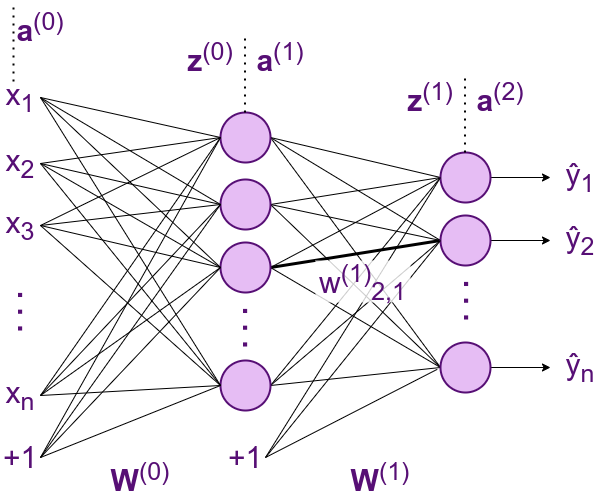

***Feedforward***:

Lembre-se que o cálculo do *forward pass* é calculado da seguinte forma:
> $a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [ ]:
class Model:

    def __init__(self, layers_dims: List[int],
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random",
                 app_batch_normal: bool = False):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions
        initialization_method: (str) indicates how to initialize the parameters
        app_batch_normal: (bool) indicates if batch normalization should be applied or not

        Example:

        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"

        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)
        self.app_batch_normal = app_batch_normal

    def __len__(self):
        return len(self.weights)

    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of
        matrices (np.array) of biases.
        """

        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # os pesos w_i,j conectam o i-ésimo neurônio na camada atual ao
            # j-ésimo neuronio na próxima camada
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])

            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            ###################################################
            # TODO: implemente outro método de inicialização - OKK
            if method.lower() == 'Glorot/Xavier': # Aula 13, slides 33 e 34
                n = (self.layers_dims[l+1] + self.layers_dims[l]) # in + out
                W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1]) * np.sqrt(2.0/n)
                b = np.zeros((1, self.layers_dims[l + 1]))
            ###################################################

            weights.append(W)
            bias.append(b)

        return weights, bias

    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implemente aqui o forward step.
        #
        # Algumas instruções adicionais:
        # Note que os pesos, o bias e as funções de ativação são variáveis da classe,
        # então você pode acessá-los via ``self``.
        #
        # Você deve armazenar a entrada Z de cada função de ativação em ``Z_list``,
        # e a saída das funções de ativação em ``activations``. Essas
        # informações serão importantes quando você implementar a backward pass.
        #
        n_layers = len(self.layers_dims)

        for l in range(0, n_layers-1):

            Z = np.dot(activation, self.weights[l]) + self.bias[l]
            if (self.app_batch_normal == True) & (l < n_layers-1):
              Z = batch_normalization(Z)
            self.Z_list.append(Z)

            activation = self.activation_funcs[l](Z)
 
            self.activations.append(activation)

        return activation

**Verificação de integridade (*sanity check*)**

In [14]:
######## checando o Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()], app_batch_normal=False)

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,
                        np.array([[2],
                                  [0]]),
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### **Otimizadores**

Depois de definir a topologia/arquitetura da sua rede neural, é hora de treiná-la. Para isso, você precisa selecionar um otimizador (por exemplo, SGD, Momentum, Adagrad, Adam, RMSProp) que irá atualizar os pesos da rede.

Implemente no local indicado:

* *Stochastic Gradient Descent* (SGD);
* Outro otimizador de sua preferência. Ele deve ser uma subclasse de ``BaseOptimizer``. Para referência, leia https://www.ruder.io/optimizing-gradient-descent/.

In [15]:
class BaseOptimizer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list) a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        ###############################################################
        # TODO: implemente o algoritmo de Stochastic Gradient Descent (SGD)
        ###############################################################
        n_layers = len(self.model.layers_dims)
        for l in range(0, n_layers-1):
           self.model.weights[l] = self.model.weights[l] - self.lr * grads[l][0]
           self.model.bias[l] = self.model.bias[l] - self.lr * grads[l][1]


####################################
# TODO: implemente outro optimizador
####################################
class AdamOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3, γ1=0.9, γ2=0.999, ε=1e-8):
        self.model = model
        self.lr = lr
        self.γ1 = γ1
        self.γ2 = γ2
        self.ε = ε

        self.mt_list=[]
        self.vt_list=[]
        self.mtb_list=[]
        self.vtb_list=[]

        n_layers = len(self.model.layers_dims)
        for l in range(0, n_layers-1):

           s1, s2 = self.model.weights[l].shape[0], self.model.weights[l].shape[1]
           mt = np.zeros((s1, s2))
           vt = np.zeros((s1, s2))
           self.mt_list.append(mt)
           self.vt_list.append(vt)

           s1, s2 = self.model.bias[l].shape[0], self.model.bias[l].shape[1]
           mtb = np.zeros((s1, s2))
           vtb = np.zeros((s1, s2))
           self.mtb_list.append(mtb)
           self.vtb_list.append(vtb)

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        n_layers = len(self.model.layers_dims)
        for l in range(0, n_layers-1):

            mt = (self.γ1 * self.mt_list[l]) + (1 - self.γ1) * grads[l][0]
            vt = (self.γ2 * self.vt_list[l]) + (1 - self.γ2) * (grads[l][0]**2)
            self.mt_list[l] = mt
            self.vt_list[l] = vt

            mt_hat = self.mt_list[l] / (1 - self.γ1)
            vt_hat = self.vt_list[l] / (1 - self.γ2)

            self.model.weights[l] = self.model.weights[l] - (self.lr / (np.sqrt(vt_hat) + self.ε)) * mt_hat

            mtb = (self.γ1 * self.mtb_list[l]) + (1 - self.γ1) * grads[l][1]
            vtb = (self.γ2 * self.vtb_list[l]) + (1 - self.γ2) * (grads[l][1]**2)
            self.mtb_list[l] = mtb
            self.vtb_list[l] = vtb

            mtb_hat = self.mtb_list[l] / (1 - self.γ1)
            vtb_hat = self.vtb_list[l] / (1 - self.γ2)

            self.model.bias[l] = self.model.bias[l] - (self.lr / (np.sqrt(vtb_hat) + self.ε)) * mtb_hat

**Verificação de integridade (*sanity check*)**

A verificação de integridade do SGD é colocada após o `Trainer` porque ela utiliza o algoritmo de retropropagação (*backpropagation*) para calcular os gradientes.

#### **Treinador (Classe `Trainer`)**

Um peso $w_{i,j}$ de uma rede neural é atualizado com base no gradiente da função de perda em relação a $w_{i,j}$. Portanto, precisamos calcular o gradiente da função de perda em relação a todos os pesos e vieses em cada camada da rede. Esse processo é chamado de retropropagação (*backpropagation*), também conhecido como etapa de retrocesso.

Implemente:
* Algoritmo de retropropagação (*backpropagation*).

> **Dica:**
>
> *Use as seguintes equações recursivas para calcular a retropropagação:*
>
> - $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial z^{(L-1)}}$
>
> - $\frac{\partial C}{\partial z^{(L)}} = [\frac{\partial C}{\partial z^{(L+1)}} \cdot W_{(L+1)}^T] \odot \frac{\partial f_{(L)}}{\partial z^{(L)}}$
>
> - $\frac{\partial C}{\partial W^{(L)}} = a^{(L)^T} \cdot \frac{\partial C}{\partial z^{(L)}}$
>
> - $\frac{\partial C}{\partial b^{(L)}} = \frac{\partial C}{\partial z^{(L)}}$
>
>onde $C$ é sua função de custo/perda, $a^{(L)}$ é a saída da última função de ativação, $z_i^{(L)}$ é a i-ésima linha da matriz $z^{(L)}$, e $\odot$ é o [produto de Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) / produto elemento a elemento.

In [ ]:
import numpy as np
import warnings

warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

def convert_prob_to_one_hot(Y):
    max_indices = np.argmax(Y, axis=1)
    binary_array = np.zeros_like(Y)
    binary_array[np.arange(Y.shape[0]), max_indices] = 1
    return binary_array

class Trainer:

    def __init__(self, model, optimizer, loss_func, early_stop=False, patience=5, tolerance=0.001):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0
        ## Early-Stop ##############################################
        self.es = early_stop
        self.es_patience = patience
        self.es_count = 0
        self.es_val_loss = sys.float_info.max
        self.es_tolerance = tolerance
        ############################################################

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return:
        A list of tuples of matrices (weights' gradient, biases' gradient) both
        in np.array format. The order of this list should be the same as the
        model's weights. For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implemente aqui o backward step.
        ############################################################
        gradients = []
        m = Y.shape[0]
        n_layers = len(self.model.layers_dims)


        dL = self.model.activation_funcs[-1].grad(Y, self.model.activations[-1])
        dL_w_saida = 1/m*(np.dot(self.model.activations[-2].T, dL))
        dl_bias_saida = 1/m*np.sum(dL, axis=0, keepdims=True)
        gradients.append((dL_w_saida, dl_bias_saida))

        dL += 0
        for l in reversed(range(n_layers-2)):
            w_mais_um = self.model.weights[l + 1]

            ac1 = self.model.activation_funcs[l].grad(self.model.Z_list[l])
            dL = np.dot(dL, w_mais_um.T)*ac1
            dL_dW = 1/m*np.dot(self.model.activations[l].T, dL)
            dl_bias_saida = 1/m*np.sum(dL, axis=0, keepdims=True)
            gradients.append((dL_dW, dl_bias_saida))

        gradients.reverse()

        return gradients
        ############################################################

    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return:
        A dictionary with the log of train and validation loss along the epochs
        """

        log_dict = {
            'epoch': [],
            'train_loss': [],
            'train_bacc': [],
            'val_loss': [],
            'val_bacc': []
        }

        self.batch_size = train_loader.batch_size

        with tqdm(total=n_epochs, unit="epoch") as outer_bar:


            for epoch in range(n_epochs):

                outer_bar.set_description(f"Epoch {epoch+1}")

                train_loss_history = []
                train_bacc_history = []
                for i, batch in enumerate(train_loader):

                    X, Y = batch
                    X = X.numpy()
                    Y = Y.numpy()
                    if Y.ndim == 1 or Y.shape[1] == 1:  # Se Y não estiver em formato one-hot
                      Y = np.eye(np.max(Y) + 1)[Y.reshape(-1)]  # Convertendo para one-hot

                    Y_pred = self.model.forward(X)



                    train_loss = self.loss_func(Y, Y_pred)
                    train_loss_history.append(train_loss)

                    Y_pred_labels = convert_prob_to_one_hot(Y_pred)

                    train_ba_score = balanced_accuracy_score(Y.argmax(axis=1), Y_pred_labels.argmax(axis=1))
                    train_bacc_history.append(train_ba_score)

                    grads = self.backward(Y)
                    self.optimizer.step(grads)

                val_loss_history = []
                val_bacc_history = []
                for i, batch in enumerate(val_loader):

                    X, Y = batch
                    X = X.numpy()
                    Y = Y.numpy()

                    Y_pred = self.model.forward(X)

                    val_loss = self.loss_func(Y, Y_pred)
                    val_loss_history.append(val_loss)
                    Y_pred_labels = convert_prob_to_one_hot(Y_pred)
                    val_ba_score = balanced_accuracy_score(Y.argmax(axis=1), Y_pred_labels.argmax(axis=1))
                    val_bacc_history.append(val_ba_score)

                train_loss = np.array(train_loss_history).mean()
                train_bacc = np.array(train_bacc_history).mean()
                val_loss = np.array(val_loss_history).mean()
                val_bacc = np.array(val_bacc_history).mean()

                log_dict['epoch'].append(epoch)
                log_dict['train_loss'].append(train_loss)
                log_dict['train_bacc'].append(train_bacc)
                log_dict['val_loss'].append(val_loss)
                log_dict['val_bacc'].append(val_bacc)



                outer_bar.update(1)
                outer_bar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss, 'train_bacc': train_bacc, 'val_bacc': val_bacc})

                if self.es == True:

                    if val_loss < self.es_val_loss - self.es_tolerance:
                        self.es_val_loss = val_loss
                        self.es_count = 0
                    else:
                        self.es_count += 1
                        if self.es_count >= self.es_patience:
                            print(f"That is it! Things are not getting better. Early stopping on epoch {epoch}.")
                            break
                ############################################################

        return log_dict

**Verificação de integridade (*sanity check*)**

In [17]:
######## checando o Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
#print(f'prediction: {prediction}')
#print(f'grads: {grads}')

# Deixamos esse valor caso você precise checar seus resultados
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])

expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [18]:
######## checando o SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### **Exemplo de uso**

Exemplo de uso do *framework* que acabamos de criar.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Função para auxiliar no plot da perda ao longo das épocas
def plot_history(history):
    """
    Plot loss history
    """

    sns.set_palette("pastel")
    pastel_colors =  sns.color_palette(["#FF6B6B", "#4ECDC4", "#45B7D1","#FAD02E", "#594F4F"])

    train_loss_color, val_loss_color, train_bacc_color, val_bacc_color = pastel_colors[0], pastel_colors[1], pastel_colors[2], pastel_colors[3]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(history['train_loss'], color=train_loss_color, label='Train Loss')
    ax1.plot(history['val_loss'], color=val_loss_color, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss and Balanced Accuracy During Training')

    ax2 = ax1.twinx()
    ax2.plot(history['train_bacc'], color=train_bacc_color, label='Train Bal. Acc.', linestyle='--')
    ax2.plot(history['val_bacc'], color=val_bacc_color, label='Validation Bal. Acc.', linestyle='--')
    ax2.set_ylabel('Balanced Accuracy')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()

def plot_history_optimizers(history1, history2):

    sns.set_palette("pastel")
    pastel_colors =  sns.color_palette(["#FF6B6B", "#4ECDC4", "#45B7D1","#FAD02E", "#594F4F"])

    train_loss_color, val_loss_color, train_bacc_color, val_bacc_color = pastel_colors[0], pastel_colors[1], pastel_colors[2], pastel_colors[3]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    fig.suptitle('Loss and Balanced Accuracy During Training', fontsize=14)

    ax1.plot(history1['train_loss'], color=train_loss_color, label='Train Loss')
    ax1.plot(history1['val_loss'], color=val_loss_color, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(history1['title'])

    ax11 = ax1.twinx()
    ax11.plot(history1['train_bacc'], color=train_bacc_color, label='Train Bal. Acc.', linestyle='--')
    ax11.plot(history1['val_bacc'], color=val_bacc_color, label='Validation Bal. Acc.', linestyle='--')
    ax11.set_ylabel('Balanced Accuracy')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax11.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')


    ax2.plot(history2['train_loss'], color=train_loss_color, label='Train Loss')
    ax2.plot(history2['val_loss'], color=val_loss_color, label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(history2['title'])

    ax22 = ax2.twinx()
    ax22.plot(history2['train_bacc'], color=train_bacc_color, label='Train Bal. Acc.', linestyle='--')
    ax22.plot(history2['val_bacc'], color=val_bacc_color, label='Validation Bal. Acc.', linestyle='--')
    ax22.set_ylabel('Balanced Accuracy')

    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax22.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

def print_last_result(history):
    print(
        f"Values in the last epoch({history['epoch'][-1]}): train loss = {history['train_loss'][-1]:.6f}, " +
        f"val loss = {history['val_loss'][-1]:.6f}, "+
        f"train bacc: {history['train_bacc'][-1]:.6f} and " +
        f"val bacc: {history['val_bacc'][-1]:.6f}"
    )

## 3. Atividades Exploratórias

Para todos os exercícios, plote a perda ao longo das épocas e reporte o desempenho do seu modelo no conjunto de validação. Cuidado com *underfitting* e *overfitting*.

1. (1 ponto) Projete uma Rede Neural, usando uma ou duas camadas ocultas, ReLU e softmax como funções de ativação, inicialização de pesos aleatória e SGD para treiná-la. Você deve escolher uma taxa de aprendizado apropriada e um número de épocas.

In [21]:
print('>>> SGD Optimizer')
model = Model([784, 512, 256, 11], [ReLU(), ReLU(), Softmax()], initialization_method='random', app_batch_normal=True)
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5)
history1 = trainer.train(200, train_loader, val_loader)
history1['title'] = 'SGD Optimizer'


>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 198.


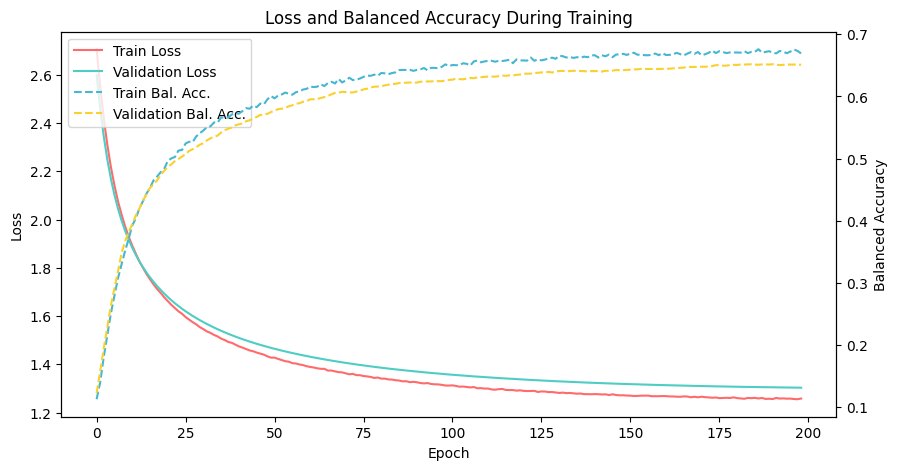

In [22]:
plot_history(history1)

> **Quais foram suas conclusões? (1-2 parágrafos)**
>
>* Para este experimento com inicialização de pesos aleatórios, utilizou-se uma arquitetura com 2 camadas ocultas compostas de 512 e 256 neurônios, respectivamente, e duas camadas de ativação ReLU para introduzir não-linearidade ao algoritmo e evitar problemas de instabilidade do gradiente (explosão ou desaparecimento). Em relação a isso, inicialmente, percebeu-se que, sem o uso do batch normalization, ocorreu um "overflow" na função softmax, indicando a explosão do gradiente. Além disso, o otimizador escolhido foi o SGD, e após alguns testes, encontrou-se que o learning rate de 1e-4 era o mais adequado para essas especificações. Adicionalmente, foi utilizado o critério de regularização do early-stopping para interromper o treinamento após 5 épocas (patience=5) sem melhorias, prevenindo overfitting.

>* O experimento foi executado por 200 épocas, parando com a intervenção do early-stopping na época 199. Observou-se uma queda suave, mais acentuada nas primeiras 30 épocas, seguida por uma redução contínua, porém com menor taxa de variação, especialmente a partir da quinquagésima época. Ao final do treino, notou-se que as losses de treino e validação se estabilizaram próximas de 1,25, enquanto as acurácias balanceadas superaram o patamar de 65%, com acurácias balanceadas finais de 66,9% para treino e 65,1% para validação.

2. (2 pontos) Experimente outras duas técnicas de inicialização de pesos e *bias* (normalização de He et al. e a outra que você implementou).

Inicialização de He

In [28]:
print('>>> SGD Optimizer')
model = Model([784, 512, 256, 11], [ReLU(), ReLU(), Softmax()], initialization_method='he', app_batch_normal=True)
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5)
history1 = trainer.train(200, train_loader, val_loader)
history1['title'] = 'SGD Optimizer'

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

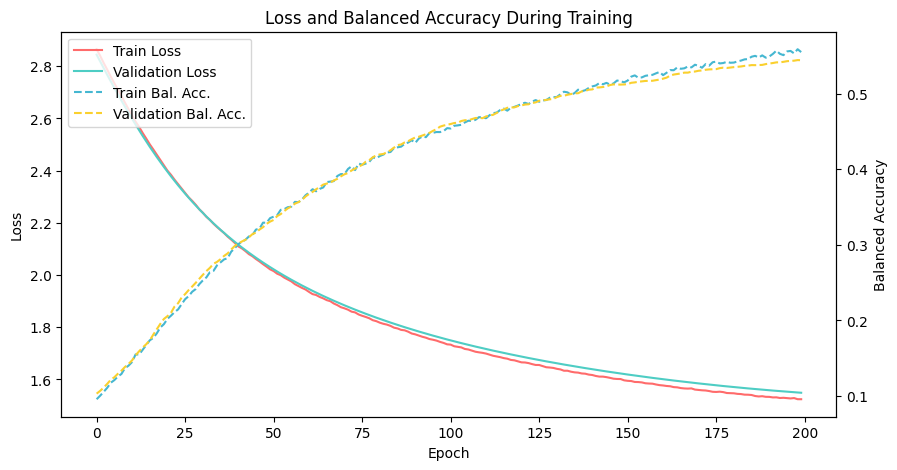

In [29]:
plot_history(history1)

Inicialização de Glorot/Xavier

In [26]:
print('>>> SGD Optimizer')
model = Model([784, 512, 256, 11], [ReLU(), ReLU(), Softmax()], initialization_method='Glorot/Xavier', app_batch_normal=True)
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5)
history1 = trainer.train(200, train_loader, val_loader)
history1['title'] = 'SGD Optimizer'

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

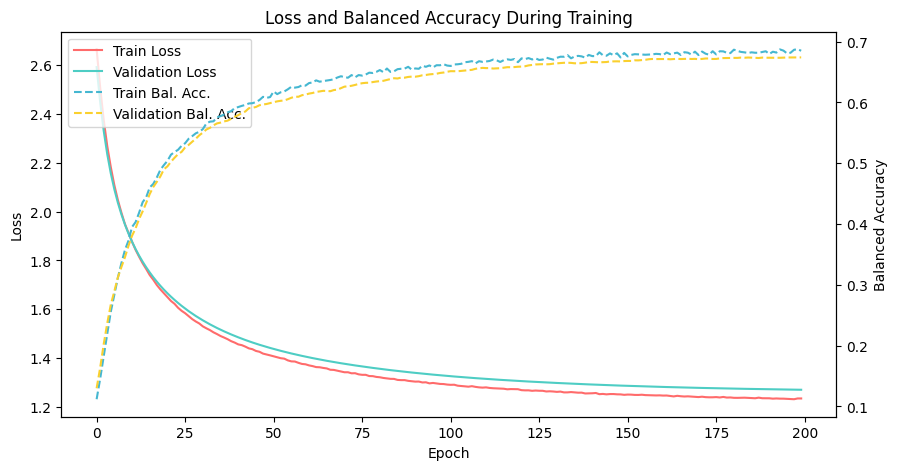

In [27]:
plot_history(history1)

> **Quais são as conclusões? Como as técnicas influenciam o desempenho dos modelos? (1-2 parágrafos)**
>
>* Analogamente ao experimento da questão anterior, utilizou-se a mesma arquitetura (com 2 camadas ocultas de 512 e 256 neurônios, 2 ativações ReLU, adição de early-stopping com configuração de patience=5 e executando o treinamento por 200 épocas). Dessa forma, a única variável a ser trocada foi o tipo de inicialização de pesos, testando-se a inicialização de He e a de Glorot/Xavier. Os learning rates foram mantidos iguais (lr = 1e-4) para comparar apenas a forma de inicialização.

>* Para a arquitetura com a inicialização de He, notou-se muito pouco progresso a cada época, mesmo sem o early-stopping ter sido ativado, o que indica uma performance ruim, com acurácias balanceadas finais de 55,5% para treino e 54,4% para validação. Já a arquitetura com inicialização de Glorot/Xavier mostrou os melhores resultados até o momento, com as losses caindo de forma suave e uma alta taxa de decrescimento ao longo das primeiras 50 épocas, seguida por um declínio mais comedido nas épocas seguintes. Para essa inicialização, o experimento completou todas as 200 épocas, sem interrupção pelo early-stopping, atingindo acurácias balanceadas finais de 68,5% para treino e 67,4% para validação. Assim, observa-se que a inicialização, ao definir o ponto inicial do mapeamento multidimensional criado pelos pesos dos neurônios, pode ter um impacto significativo no desempenho.

3. (1 ponto) Escolha a técnica de inicialização de pesos e *bias* que resultou no melhor desempenho e experimente a outra função de ativação que você implementou.

In [30]:
print('>>> SGD Optimizer')
model = Model([784, 512, 256, 11], [Sigmoid(), Sigmoid(), Softmax()], initialization_method='Glorot/Xavier', app_batch_normal=True)
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5)
history1 = trainer.train(200, train_loader, val_loader)
history1['title'] = 'SGD Optimizer'

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

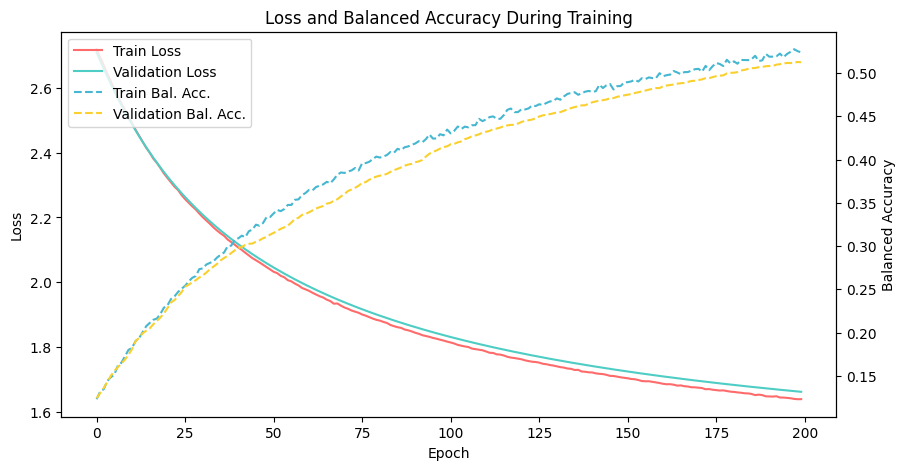

In [31]:
plot_history(history1)

> **Quais são as conclusões? Isso faz alguma diferença nos resultados? (1-2 parágrafos)**
>
>* Ao aproveitar a arquitetura com inicialização de Glorot/Xavier e todas as outras especificações constantes, alternando apenas as duas funções de ativação de ReLU para Sigmoid, notou-se uma grande diferença. No caso anterior, que havia sido nosso melhor resultado até então com a ativação ReLU, foram alcançadas as acurácias balanceadas finais de 68,5% para treino e 67,4% para validação. Infelizmente, ao substituir pela ativação Sigmoid, percebeu-se uma queda considerável de desempenho, com as acurácias balanceadas de treino e validação estabilizando-se pouco acima do patamar de 50%, sendo as acurácias balanceadas finais de 51,3% para treino e 52,4% para validação. O código completou as 200 épocas sem a necessidade de early-stopping, o que indicou que ainda havia potencial de melhora para outras épocas; mas, como medida de comparação, decidiu-se manter as 200 épocas nesta etapa.

>* Portanto, nota-se que a alteração de uma única configuração já é suficiente para alterar sobremaneira a performance. Nesse experimento, observou-se que, para a melhor arquitetura anterior, a ativação Sigmoid afetou negativamente o desempenho de forma considerável. Além disso, com base nos outros experimentos e testes realizados, percebeu-se que ajustar levemente o learning rate ou até mesmo a quantidade de neurônios em uma camada já poderia ser suficiente para mudar completamente os resultados em performance.

4. (3 pontos) Explore diferentes arquiteturas de rede, variando o número de camadas e o número de neurônios em cada camada. É um experimento empírico.

In [ ]:
architeture = [
    ([784, 512, 256, 128, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 512, 512, 256, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 2048, 2048, 2048, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 2048, 1024, 512, 256, 128, 11], [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()])
]

initialization = [

    'Glorot/Xavier'
]

learning_rate = [

    5e-4,
    5e-5,
    5e-6,

]

def train_architeture(architeture, initialization, learning_rate, epochs=1000, patience=5, tolerance=0.001):

  for arch in architeture:
      print('\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
      print(f'>>> Experiments for architeture {arch[0]}')
      print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
      for init in initialization:
          for lr in learning_rate:
              print(f'\n>>>>>> Initialization method {init} with learning rate {lr}\n')

              print('>>> SGD Optimizer')
              model = Model(arch[0], arch[1], initialization_method=init, app_batch_normal=True)
              opt = SGDOptimizer(model, lr=lr)
              trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=patience, tolerance=tolerance)
              history1 = trainer.train(epochs, train_loader, val_loader)
              history1['title'] = 'SGD Optimizer'
              print_last_result(history1)

              plot_history(history1)


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>> Experiments for architeture [784, 512, 256, 128, 11]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>> Initialization method Glorot/Xavier with learning rate 0.0005

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 10.
Values in the last epoch(10): train loss = 1.396531, val loss = 1.439702, train bacc: 0.636439 and val bacc: 0.620745


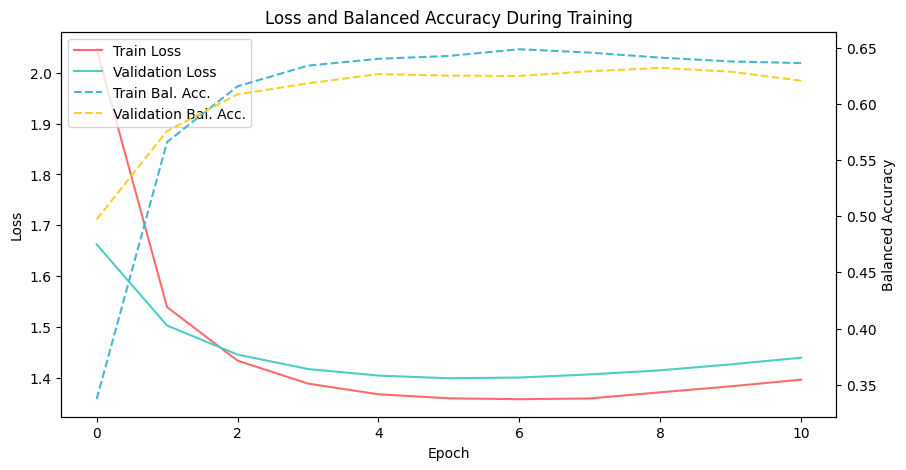


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-05

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 69.
Values in the last epoch(69): train loss = 1.275882, val loss = 1.328963, train bacc: 0.663440 and val bacc: 0.634383


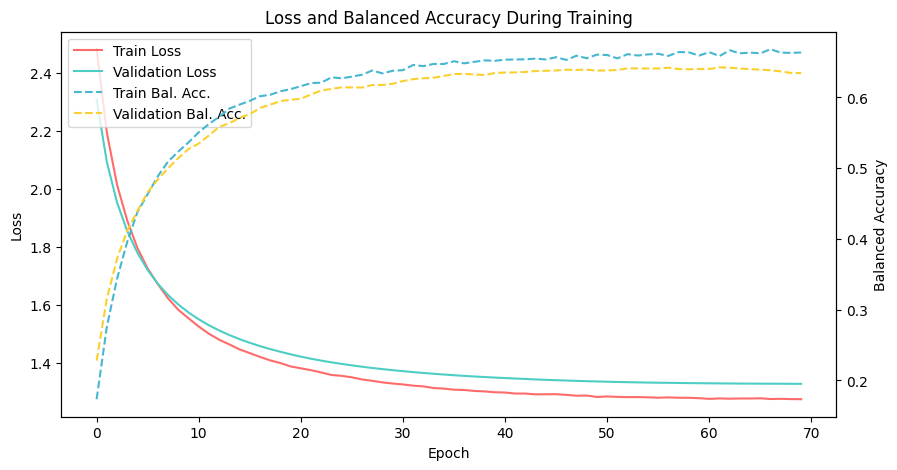


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-06

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

Values in the last epoch(199): train loss = 1.397225, val loss = 1.451252, train bacc: 0.614519 and val bacc: 0.591090


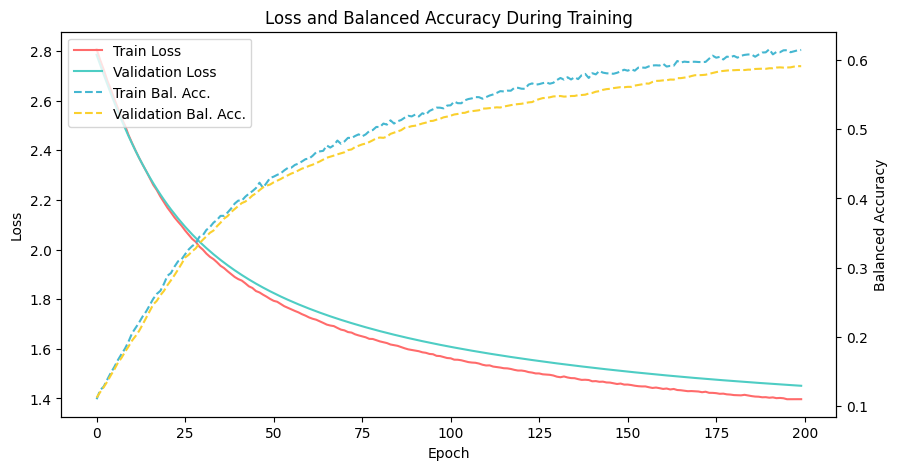


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>> Experiments for architeture [784, 512, 512, 256, 11]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>> Initialization method Glorot/Xavier with learning rate 0.0005

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 8.
Values in the last epoch(8): train loss = 1.276523, val loss = 1.317131, train bacc: 0.660152 and val bacc: 0.641399


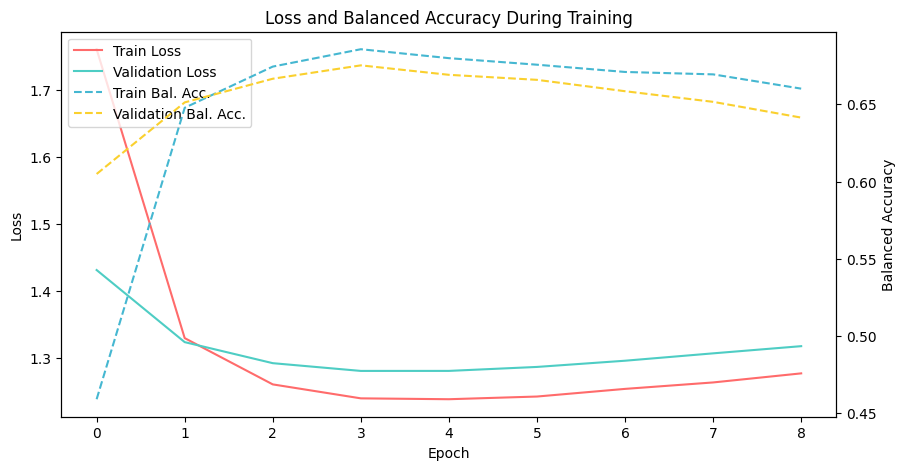


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-05

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 47.
Values in the last epoch(47): train loss = 1.270581, val loss = 1.313663, train bacc: 0.674061 and val bacc: 0.653814


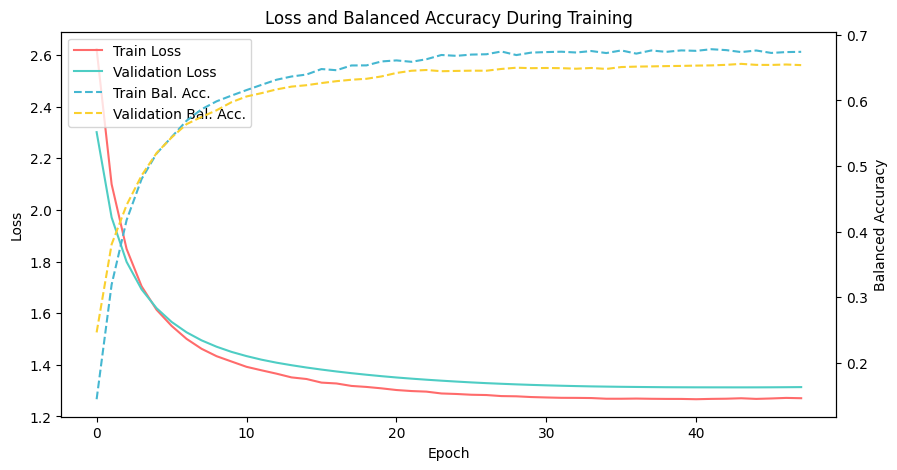


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-06

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

Values in the last epoch(199): train loss = 1.245338, val loss = 1.302094, train bacc: 0.686600 and val bacc: 0.663086


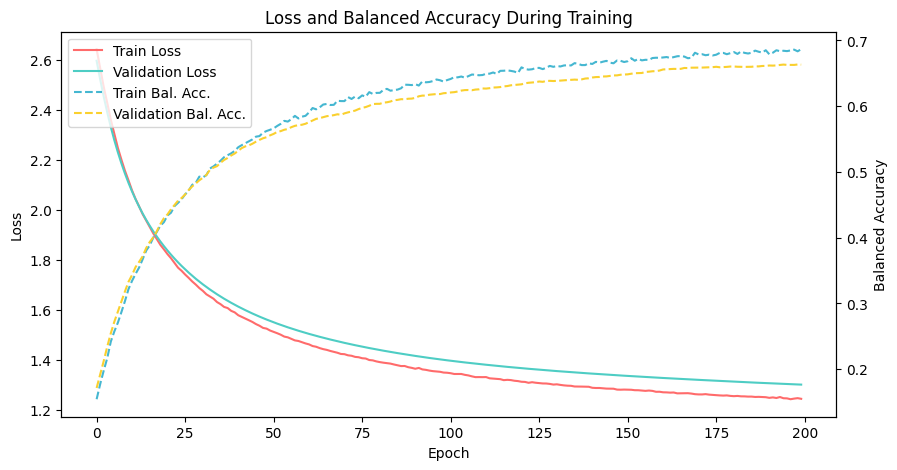


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>> Experiments for architeture [784, 2048, 2048, 2048, 11]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>> Initialization method Glorot/Xavier with learning rate 0.0005

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 5.
Values in the last epoch(5): train loss = 1.315202, val loss = 1.349068, train bacc: 0.641851 and val bacc: 0.629773


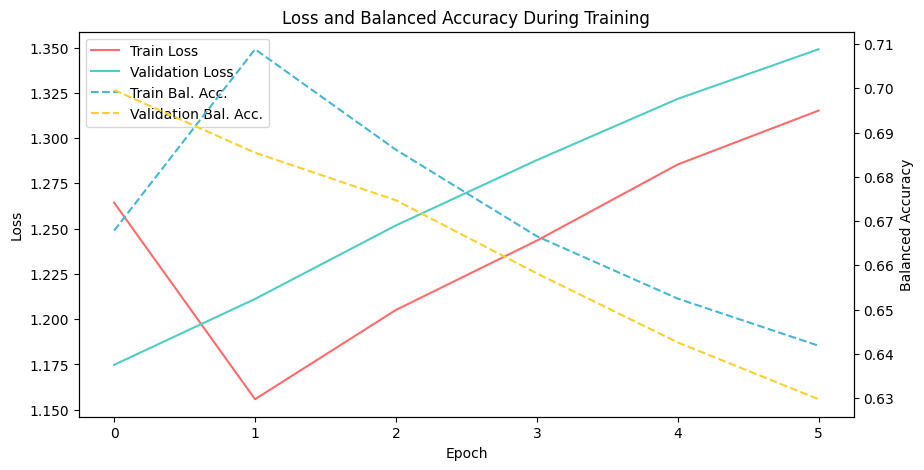


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-05

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 11.
Values in the last epoch(11): train loss = 1.130152, val loss = 1.189961, train bacc: 0.722330 and val bacc: 0.698941


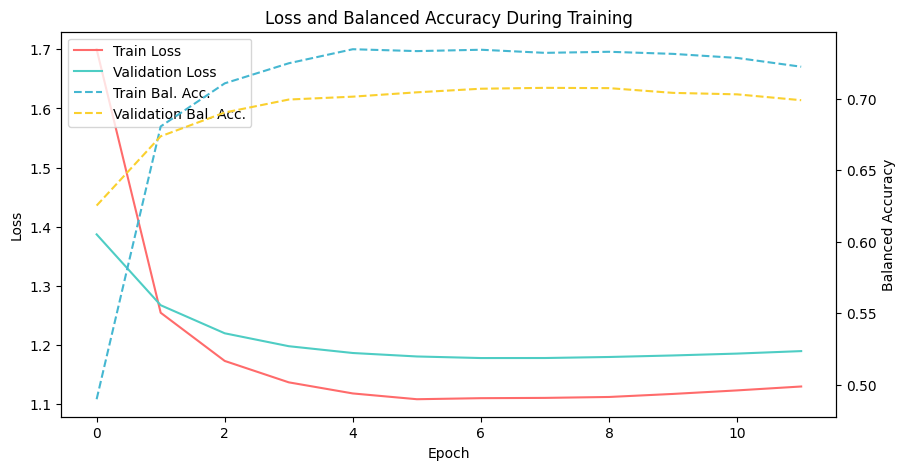


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-06

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 72.
Values in the last epoch(72): train loss = 1.100009, val loss = 1.172081, train bacc: 0.738998 and val bacc: 0.709977


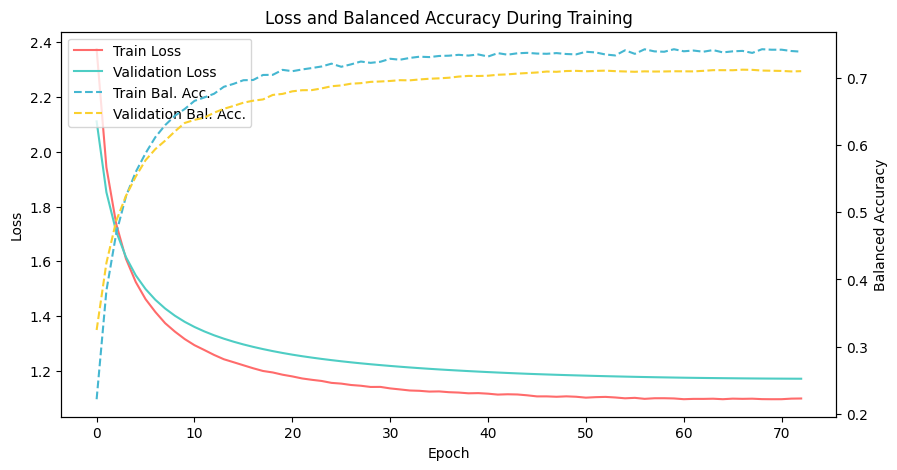


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>> Experiments for architeture [784, 2048, 1024, 512, 256, 128, 11]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>> Initialization method Glorot/Xavier with learning rate 0.0005

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 5.
Values in the last epoch(5): train loss = 1.999160, val loss = 1.995837, train bacc: 0.276913 and val bacc: 0.296706


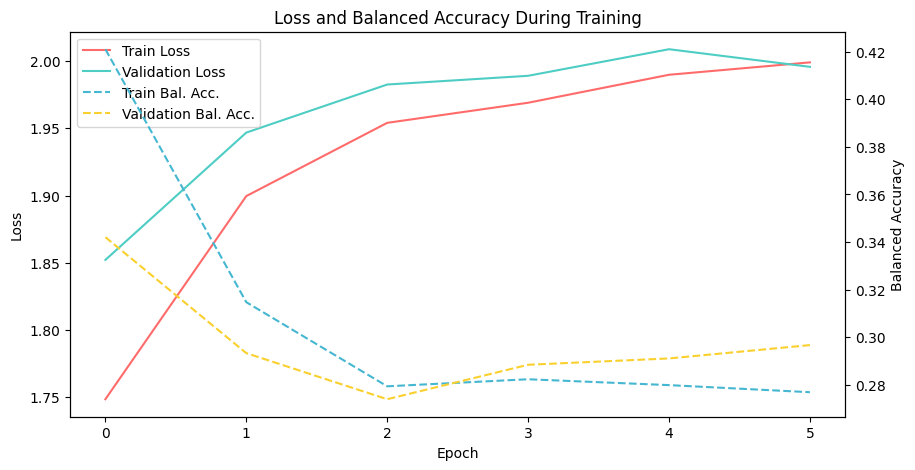


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-05

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 5.
Values in the last epoch(5): train loss = 1.749638, val loss = 1.793377, train bacc: 0.415488 and val bacc: 0.408004


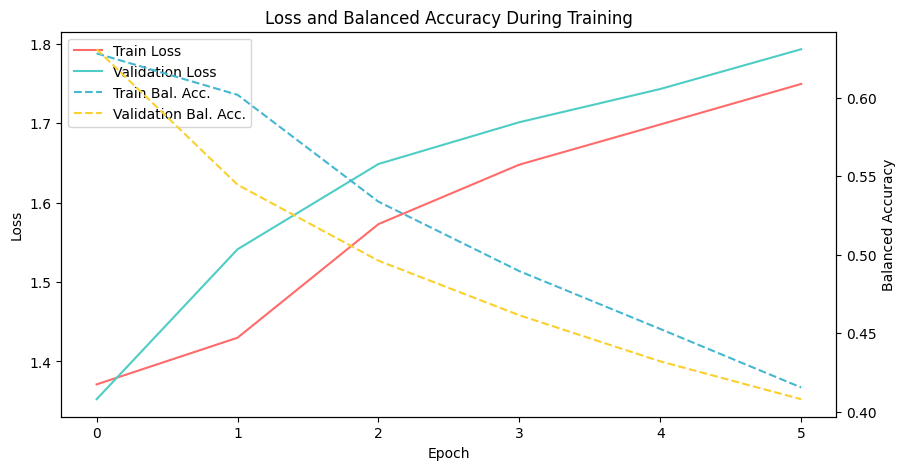


>>>>>> Initialization method Glorot/Xavier with learning rate 5e-06

>>> SGD Optimizer


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 7.
Values in the last epoch(7): train loss = 1.318842, val loss = 1.370077, train bacc: 0.656523 and val bacc: 0.633235


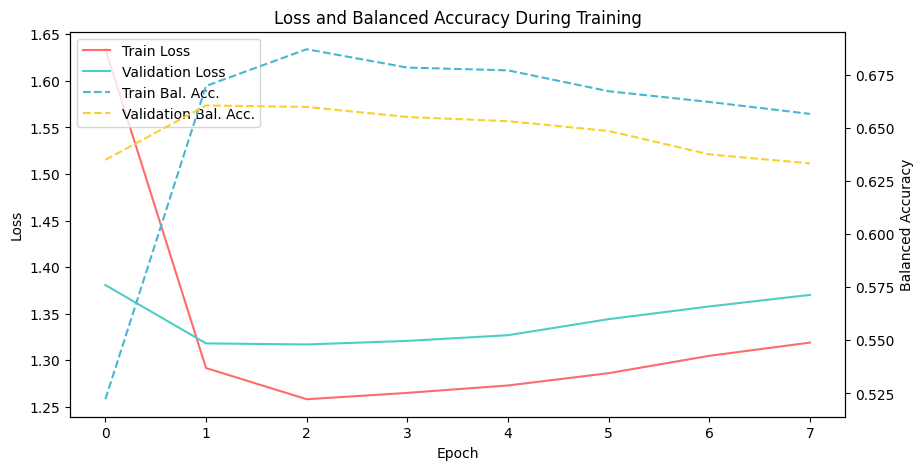

In [ ]:
epochs = 200
train_architeture(architeture, initialization, learning_rate, epochs=epochs)

> **Quais são as conclusões? Como o número de camadas impacta o desempenho dos modelos? (2-4 parágrafos)**
>
>* A fim de comparar múltiplas arquiteturas em diferentes learning rates propôs-se um teste em grid realizando a combinação das seguintes arquiteturas:
    ([784, 512, 256, 128, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 512, 512, 256, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 2048, 2048, 2048, 11], [ReLU(), ReLU(), ReLU(), Softmax()]),
    ([784, 2048, 1024, 512, 256, 128, 11], [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()]) em conjunto com 3 tipos de learning rates \(5e-4,5e-5,5e-6,). Totalizando 4x3 = 12 tipos de arquiteturas, variando em cada umas delas o número de neurônios por camada e número de camadas ocultas.  Utilizou-se early-stopping com o patience = 5 e um pequeno nível de tolerância(0.001). Assim sendo, um dos objetivos principais ao executar esse experimento foi a atenção ao overfitting.

>* Optou-se por utilizar a inicialização Glorot/Xavier e as funções de ativação ReLU pois haviam sido de modo geral os melhores itens dos modelos treinados anteriormente e também considerando o número de combinações já estar relativamente grande ( sendo esse o exercício que mais demorou para ser executado - tivemos problemas com o google colab e a partir disso executamos o código em nossos hardwares localmente). 

>* Portanto, analisando os resultados após a execução do código notamos que apresentou uma grande variabilidade de performance entre as arquiteturas postas à prova. Das 12 arquiteturas 3 delas tiveram um resultado extremamente ruim ( inclusive uma delas divergindo completamente), entende-se o principal causador desses três casos é o learning rate inapropriado, de tal modo que a mesma configuração de camadas com outros learning rates não apresentou esses resultados. A outra parte dos resultados apresentou resultados próximos ou acima de 60% de acurácia balanceada, alguns desses acima até de 70% no treino e validação( sendo um deles nossa melhor arquitetura).
>*

5. (2 pontos) Escolha a melhor arquitetura de rede e treine seu modelo usando o otimizador que você escolheu implementar.

In [ ]:
model = Model(layers_dims=[784, 2048, 2048, 2048, 11], activation_funcs=[ReLU(), ReLU(), ReLU(), Softmax()],initialization_method='Glorot/Xavier',  app_batch_normal=True)
opt = AdamOptimizer(model, lr=5e-4)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5,tolerance=0.001)
history1 = trainer.train(200, train_loader, val_loader)


  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 48.


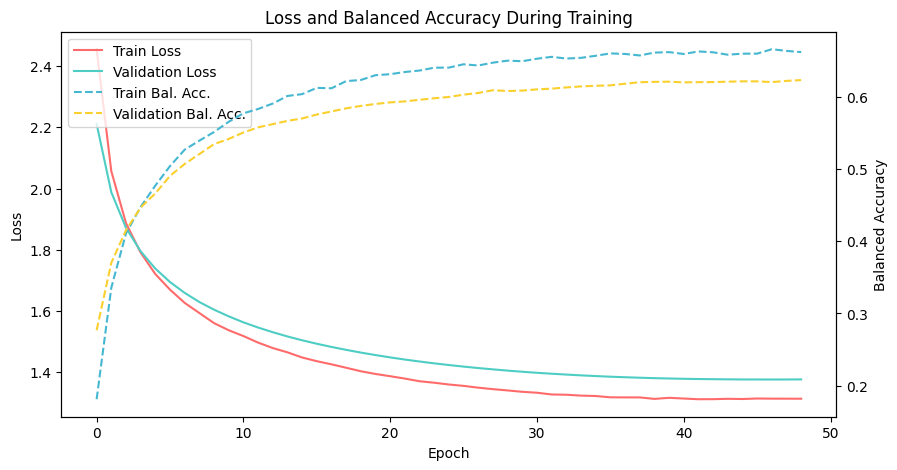

In [90]:
plot_history(history1)

> **Quais são as conclusões? A mudança de otimizador impacta de alguma forma a curva de perda ao longo das épocas? (1-2 parágrafos)**
>
>* Utilizando-se a melhor arquitetura, mas com o otimizador ADAM notou-se mais dificuldade em convergir para um ponto de mínimo melhor que o do SGD. Acredita-se o número de cálculos iterativos de processamento em comparação com o SGD e a dificuldade de encontrar um learning rate adequado podem ter promovido o resultado. No fim, percebe-se a queda inicialmente considerável das losses de treino e validação, em contrapartida as acurácias balanceadas estabilizaram num patamar próximo de 63% ( sendo interrompido na época 49 pelo early-stopping com 62.2% de acurácia balanceada para validação e 66.2% para de treino.) Considerando essa interrupção do early-stopping, visando evitar o overfitting, promoveu a parada por volta desse patamar.

>* Com isso, ratifica-se o exposto de que os resultados podem ser bastante diferentes com uma pequena alteração. O grupo acredita que mais testes seriam necessários( com outros learning rates e mudança de outras componentes) para obter um resultado mais próximo da arquitetura campeã.

6. (1 ponto) Escolha seu melhor modelo, faça previsões para o conjunto de teste e envie-as para a competição [Redes Neurais – Tarefa #3 de MC886/MO444 2024S2](https://www.kaggle.com/t/f3a05870932d4bb49d59d18cc4a44a2d) no Kaggle. Reporte sua pontuação considerando a tabela de classificação pública. A plataforma calculará automaticamente a métrica de avaliação, a **acurácia balanceada**.

> **Observação:** Não se preocupe apenas com o resultado do seu modelo. O seu resultado no placar não irá influenciar a sua nota nesta atividade :).

### Gerando predição para o Kaggle

In [ ]:
# ## Salvando os parametros do melhor modelo

# ########## Modelo qualquer por enquanto apenas para ter o model
# print('>>> SGD Optimizer')

model = Model(layers_dims=[784, 2048, 2048, 2048, 11], activation_funcs=[ReLU(), ReLU(), ReLU(), Softmax()],initialization_method='Glorot/Xavier',  app_batch_normal=True)
opt = SGDOptimizer(model, lr=5e-6)
trainer = Trainer(model, opt, CrossEntropy(), early_stop=True, patience=5,tolerance=0.001)
history1 = trainer.train(200, train_loader, val_loader)
history1['title'] = 'BEST MODEL'

  0%|          | 0/200 [00:00<?, ?epoch/s]

That is it! Things are not getting better. Early stopping on epoch 71.


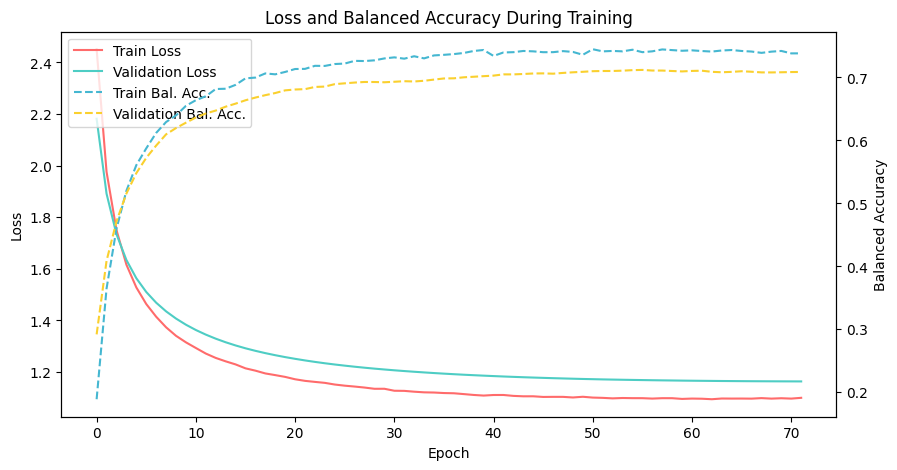

In [ ]:
plot_history(history1)

In [ ]:
# import pickle

# model_parameters = {
#     'weights': model.weights,
#     'bias': model.bias
# }

# with open('model_parameters_best_model.pkl', 'wb') as f:
#     pickle.dump(model_parameters, f)

# print("Parâmetros do melhor modelo salvos com sucesso.")

Parâmetros do melhor modelo salvos com sucesso.


In [95]:
# Aqui setar as configurações específicas - valor abaixo apenas como teste

# model = Model(layers_dims=[784, 512, 256, 11], activation_funcs=[Sigmoid(), Sigmoid(), Softmax()],initialization_method='Glorot/Xavier',  app_batch_normal=True  )

best_model = Model(layers_dims=[784, 2048, 2048, 2048, 11], activation_funcs=[ReLU(), ReLU(), ReLU(), Softmax()],initialization_method='Glorot/Xavier',  app_batch_normal=True)

In [96]:
## Importar
with open('model_parameters_best_model.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

model.weights = loaded_params['weights']
model.bias = loaded_params['bias']


In [97]:
model.weights = loaded_params['weights']
model.bias = loaded_params['bias']

In [98]:
predicoes = []

for batch in test_loader:
    x_batch = batch.numpy()  
    y_pred_batch = model.forward(x_batch)
    predicoes.append(y_pred_batch)

predicoes = np.vstack(predicoes)
rotulos_pred = np.argmax(predicoes, axis=1)

predicoes

array([[0.02957804, 0.08901624, 0.1163457 , ..., 0.06672828, 0.06154888,
        0.35100208],
       [0.07389201, 0.09058199, 0.05510513, ..., 0.01395932, 0.02621996,
        0.03917635],
       [0.07359342, 0.14616584, 0.08279566, ..., 0.0617612 , 0.21978781,
        0.05396016],
       ...,
       [0.09871425, 0.13713701, 0.09234944, ..., 0.08935702, 0.21576756,
        0.07528442],
       [0.03480617, 0.0530097 , 0.04414401, ..., 0.04800327, 0.17143712,
        0.04300278],
       [0.0990748 , 0.15096734, 0.14926843, ..., 0.08676782, 0.21642781,
        0.02659   ]])

In [99]:
df = pd.DataFrame({'id': np.arange(1, x_test.shape[0] + 1),'Label': np.argmax(predicoes, axis=1)})
df


,id,Label
0,1,10
1,2,3
2,3,9
3,4,9
4,5,7
...,...,...
5302,5303,8
5303,5304,1
5304,5305,9
5305,5306,6


In [ ]:
# df.to_csv('best_model_final_.csv', index=False,sep=',')

> **Quais foram suas conclusões? (1-2 parágrafos)**
>
>* De acordo com os resultados encontrados, alcançou-se um resultado moderado no placar, com quase 70% de acurácia balanceada de teste. Vale notar implementou-se a estratégia de early-stopping (com testes no patience e nível de tolerância) de modo a evitar ao máximo o overfitting. Além disso, ao longo do trabalho, testou-se mais uma técnica de regularização – o dropout conjuntamente com o batch normalization. Entretanto, após os testes, decidimos não incluí-lo, visto que nossa implementação não obteve desempenho satisfatório para o propósito da atividade.

>* Dito isso, a conclusão que se obtém desta atividade, não somente deste último exercício, mas do trabalho como um todo, mostra que existem múltiplas abordagens a serem testadas e que, se devidamente implementadas, conseguiriam enriquecer muito mais o poder preditivo do modelo.


---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**